In [84]:
import pandas as pd

# набор функций для создание датафреймов по континенту из общего датафрейма 'аэропорт + загруженность'

def region_parser(df : pd.DataFrame):
    list_of_region = pd.DataFrame(df['region'].transform(lambda x: x.split('/')[0]))
    return list_of_region

def where_the_hell_the_USA(df : pd.DataFrame):
    df_tmp = region_parser(df).copy()
    df_tmp = pd.merge(df[df_tmp['region'] == 'America'],df[df['latitude'] > 12.27])
    df_tmp['region'] = 'america north'
    return df_tmp

def tequila(df : pd.DataFrame):
    df_tmp = region_parser(df).copy()
    df_tmp = pd.merge(df[df_tmp['region'] == 'America'],df[df['latitude'] <= 12.27])
    df_tmp['region'] = 'america south'
    return df_tmp

def back_to_USSR(df : pd.DataFrame):
    df_tmp = region_parser(df).copy()
    df_tmp = pd.merge(df[df_tmp['region'] == 'Europe'],df[df_tmp['region'] == 'Asia'],how='outer')
    df_tmp['region'] = df_tmp['region'].apply(lambda x: x.lower())
    df_tmp['region'] = 'eurasia'
    return df_tmp

def n_word(df : pd.DataFrame):
    df_tmp = region_parser(df).copy()
    df_tmp = df[df_tmp['region'] == 'Africa']
    df_tmp['region'] = 'africa'
    return df_tmp

def upside_down(df : pd.DataFrame):
    df_tmp = region_parser(df).copy()
    df_tmp = df[df_tmp['region'] == 'Australia']
    df_tmp['region'] = 'australia'
    return df_tmp

# подготавливаем датафрейм списка 'аэропорты'

df_airports = pd.read_csv('airports.dat')
df_airports = df_airports.iloc[:,[4,6,7,11]]
df_airports.columns = ['IATA','latitude','longitude','region']

df_airports.drop_duplicates()
df_airports.drop(df_airports[df_airports['IATA'] == '\\N'].index,inplace=True)
df_airports.drop(df_airports[df_airports['region'] == '\\N'].index,inplace=True)

# подготавливаем датафрейм списка 'маршрут рейсов'

df_routes = pd.read_csv('routes.dat')
df_routes = df_routes.iloc[:,[2,4]]
df_routes.columns = ['from','to']

df_routes.drop_duplicates()
df_routes.drop(df_routes[df_routes['from'] == '\\N'].index,inplace=True)
df_routes.drop(df_routes[df_routes['to'] == '\\N'].index,inplace=True)

# подготавливаем датафрейм 'загруженность'

df_load = pd.merge(df_routes.groupby('from').count().reset_index(),df_routes.groupby('to').count().reset_index(),left_on='from',right_on='to',how='outer').fillna(0)
df_load.columns = ['from_x','to_x','from_y','to_y']
df_load.rename(columns={'from_x':'IATA','to_x':'deparue_count','to_y':'arrival_count'},inplace=True)
df_load.drop(columns='from_y',inplace=True)
df_load['load'] = df_load['deparue_count'] + df_load['arrival_count']

# подготавливаем датафрейм 'аэропорт + загруженность'

df_merged_airport_load = pd.merge(df_airports,df_load)
# # df_merged_airport_load.set_index('IATA',inplace=True)
df_merged_airport_load.sort_values('latitude',inplace=True)
# print(df_merged_airport_load)

# выбор пары континентов

def select_two_continents(df= pd.DataFrame,continent_1='',continent_2=''): 
    continents = {'africa':n_word,'america north':where_the_hell_the_USA,'america south':tequila,'australia':upside_down,'eurasia':back_to_USSR}
    if continent_1 == '' or continent_2 == '':
        continent_1 = input('Enter the 1st one:\n(africa,america north,america south,australia,eurasia)\n').lower()
        continent_2 = input('Enter the 2nd one:\n(africa,america north,america south,australia,eurasia)\n').lower()
    if continent_1 in continents and continent_2 in continents:
        print('selected continents:',continent_1,'and',continent_2+'\n')
        continent_1 = continents[continent_1]
        continent_2 = continents[continent_2]
        continent_a = continent_1(df)
        continent_b = continent_2(df)
        return  continent_a,continent_b 
    else:
        print('ther are no such continent! try once more time\n')
        select_two_continents()

def n_most_loaded(df:pd.DataFrame,n=3):
    df_tmp = df.copy()
    df_tmp = df_tmp.sort_values('load',ascending=False)
    df_tmp = df_tmp.iloc[:n]
    return df_tmp

def all_airports_of_continent(df:pd.DataFrame):
    return df.index.format()

def df_a_b_prep(df:pd.DataFrame,continent_a:pd.DataFrame,continent_b:pd.DataFrame):
    df_tmp = df.copy()
    df_tmp = pd.merge(continent_a,df_tmp,left_on='IATA',right_on='from')
    df_tmp.drop(columns=['from'],inplace=True)
    df_tmp = pd.merge(df_tmp,continent_b,left_on='to',right_on='IATA')
    df_tmp.drop(columns=['IATA_x'],inplace=True)
    df_tmp.rename(columns={'IATA_y':'IATA','to':'from'},inplace=True)
    df_tmp.columns = ['IATA','from']
    return df_tmp

def count_of_popular(df:pd.DataFrame,most_popular_a:pd.DataFrame,continent_b:pd.DataFrame):
    df_tmp = df_a_b_prep(df,most_popular_a,continent_b)
    df_tmp = df_tmp.groupby('IATA').count()
    return df_tmp

def percent_a_b(df_routes:pd.DataFrame,df_a:pd.DataFrame,df_b:pd.DataFrame):
    df_tmp = df_a_b_prep(df_routes,df_a,df_b)
    df_tmp = df_tmp.groupby('IATA').count()
    df_tmp.rename(columns={'from':'arriving_percent'},inplace=True)
    df_tmp['arriving_percent'] = df_tmp['arriving_percent'].apply(lambda x: x/df_tmp['arriving_percent'].sum()*100)
    return df_tmp.sort_values(by='arriving_percent',ascending=False)

# тестовый набор данных

continent_a,continent_b = select_two_continents(df_merged_airport_load,'eurasia','america north')
continent_a = n_most_loaded(continent_a)
# continent_b = n_most_loaded(continent_b)

# подготовка набора к использованию в df_a_b_prep
# continent_a.drop(columns=['latitude', 'longitude', 'region', 'deparue_count', 'arrival_count', 'load'],inplace=True)
# continent_b.drop(columns=['latitude', 'longitude', 'region', 'deparue_count', 'arrival_count', 'load'],inplace=True)

# print(count_of_popular(df_routes,continent_a,continent_b))

# print(percent_a_b(df_routes,continent_a,continent_b))

selected continents: eurasia and america north



<AxesSubplot: >

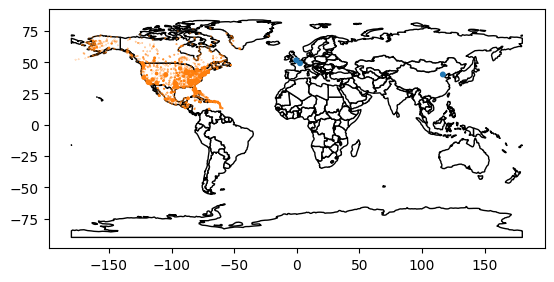

In [87]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_continent_a = gpd.GeoDataFrame(continent_a,geometry=gpd.points_from_xy(continent_a.longitude,continent_a.latitude))
gdf_continent_b = gpd.GeoDataFrame(continent_b,geometry=gpd.points_from_xy(continent_b.longitude,continent_b.latitude))
world = world.plot(color='white',edgecolor='black')
gdf_continent_a.plot(ax=world,markersize=gdf_continent_a.load/100)
gdf_continent_b.plot(ax=world,markersize=gdf_continent_b.load/100)